In [124]:
# За порамнување на figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# Големина на figure за да се доволно големи сликите
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [126]:
def addImages(img1, img2):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    
    if(img1.shape[1] > img2.shape[1]):
        print("ERROR")
        
    result = np.zeros((img1.shape[0], img2.shape[1], 4), dtype=np.uint8)
    for y in range(img1.shape[0]):
        for x in range(img1.shape[1]):            
            z = img1[y, x, 3]
            if(z <= 25):
                result[y][x] = img2[y][x]
            else:
                result[y][x] = img1[y][x]
        
        for x in range(img1.shape[1], img2.shape[1]):
            result[y][x] = img2[y][x]
    
    return result

In [127]:
# Функција која спојува 2 слики во панорама, ако имаат доволно слични карактеристики
def stitch(img1, img2, detectortype, matchertype, percentagematches):
    
    # За наоѓање на дескрипторите и клучните точки, подобро е процесирање
    # врз монохроматска / црно-бела слика, затоа ги конвертираме сликите.
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY)

    # Приказ на 2те слики
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16, 9))
    ax1.set_xlabel("Слика 1", fontsize=14)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGRA2RGB))
    ax2.set_xlabel("Слика 2", fontsize=14)
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGRA2RGB))
    plt.show()

    descriptorDetector = None
    k1 = None
    k2 = None
    d1 = None
    d2 = None
    
    # Детекција на дескрипторите и клучните точки на дадените црно-бели слики,
    # со користење на еден од постоечките алгоритми како SIFT, SURT, ORB, etc.
    if detectortype == "SIFT":
        descriptorDetector = cv2.SIFT_create()
        k1, d1 = descriptorDetector.detectAndCompute(img1_gray, None)
        k2, d2 = descriptorDetector.detectAndCompute(img2_gray, None)
    elif detectortype == "ORB":
        descriptorDetector = cv2.ORB_create()
        k1, d1 = descriptorDetector.detectAndCompute(img1_gray, None)
        k2, d2 = descriptorDetector.detectAndCompute(img2_gray, None)

    matcher = None
    
    # Matcher кој (зависно од методот), за дадени 2 листи на дескриптори, ги
    # наоѓа паровите дескриптори од 2те слики кои се доволно слични / исти
    if(matchertype == "BRUTEFORCE"):
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE)
    elif(matchertype == "FLANN"):
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_FLANNBASED)
    matches = matcher.match(d1, d2, None)
    
    # Ги сортираме паровите поклопувања според колку се оддалечени меѓусебе,
    # во однос на аголот, насоката и големината на дескрипторот.
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    # Ги процесираме само најдобрите X проценти
    num_good_matches = int(len(matches) * percentageMatches)
    good_matches = matches[:num_good_matches]

    # За да се создаде хомографија од една на друга рамнина, потребни се најмалку 4 точки.
    if(len(good_matches) < 4):
        print("ERROR! Нема најмалку 4 точки за да се калкулира хомографијата!")

    # Приказ на најдените парови клучни точки кои се доволно слични, на слика
    imMatches = cv2.drawMatches(img1, k1, img2, k2, good_matches, None, flags=2)
    plt.xlabel("Најдени поклопувачки парови", fontsize=14)
    plt.imshow(cv2.cvtColor(imMatches, cv2.COLOR_BGRA2RGB))
    plt.show()

    # Локациите на најдобрите парови, како низи точки
    points1 = np.array([k1[match.queryIdx].pt for match in good_matches], dtype=np.float32)
    points1 = points1.reshape((-1, 1, 2))
    points2 = np.array([k2[match.trainIdx].pt for match in good_matches], dtype=np.float32)
    points2 = points2.reshape((-1, 1, 2))

    # Според RANSAC алгоритмот се отфрлаат неповолните точки (outliers) и се пресметува
    # хомографска трансформациска матрица, која слика 2 ја трансформира на иста рамнина со слика 1
    homography, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
    result2to1 = cv2.warpPerspective(img2, homography, (img1.shape[1] + img2.shape[1], img1.shape[0] + img2.shape[0]))
    plt.xlabel("Warped Слика2 според хомографијата", fontsize=14)
    plt.imshow(cv2.cvtColor(result2to1, cv2.COLOR_BGRA2RGB))
    plt.show()

    # Едноставна замена на делот на новодобиената warped слика, за да ја вметнеме првата слика
    result2to1 = addImages(img1, result2to1)
    plt.xlabel("Резултатот од сврзување на сликите", fontsize=14)
    plt.imshow(cv2.cvtColor(result2to1, cv2.COLOR_BGRA2RGB))
    plt.show()
    
    result = result2to1
    
    # Правиме threshold за да се најдат контурите, за да може да го тргнеме новодобиениот црн дел
    # на крајот на сликата, добиен од хомографската трансформација на втората слика.
    gray_result = cv2.cvtColor(result, cv2.COLOR_BGRA2GRAY)
    threshold = cv2.threshold(gray_result, 0, 255, cv2.THRESH_BINARY)[1]
    contours, hierarchy = cv2.findContours(threshold.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    res_contours = cv2.drawContours(result.copy(), contours, -1, (0, 255, 255))

    # Приказ на контурите
    plt.xlabel("Најдени контури", fontsize=14)
    plt.imshow(cv2.cvtColor(res_contours, cv2.COLOR_BGRA2RGB))
    plt.show()

    # Најди bounding box на контурата која има најголема плоштина, без црниот дел
    contour_maxArea = max(contours, key=cv2.contourArea)
    (x, y, width, height) = cv2.boundingRect(contour_maxArea)
    result = result[y: y + height, x: x + width]
    plt.xlabel("Најголема видлива контура", fontsize=14)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGRA2RGB))
    plt.show()

    return result
        

In [128]:
def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    img_rgba = cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT, borderValue=0)
    return img_rgba

In [129]:
# Вчитување на листата слики и правење нова листа со самите матрици на сликите
list_image_names = ["images/diamondhead-05.png", "images/diamondhead-06.png", "images/diamondhead-07.png", "images/diamondhead-08.png", "images/diamondhead-09.png", "images/diamondhead-10.png", "images/diamondhead-11.png"]
# list_image_names = ["images/S1.jpg", "images/S2.jpg", "images/S3.jpg", "images/S5.jpg"]
images = []
for name in list_image_names:
    images.append(cv2.imread(name, cv2.IMREAD_COLOR))

images_copy_for_stitcher = images.copy()

# Цилиндричен warping
cylinder_images = []
for img in images:
    h, w = img.shape[:2]
    K = np.array([[1800,0,w/2],[0,600,h/2],[0,0,1]])
    cylinder_images.append(cylindricalWarp(img, K))

# Параметри
descriptorDetector = "SIFT" # SIFT, ORB
matcherType = "FLANN" # FLANN, BRUTEFORCE
percentageMatches = 0.3 # [0.0, 1.0]

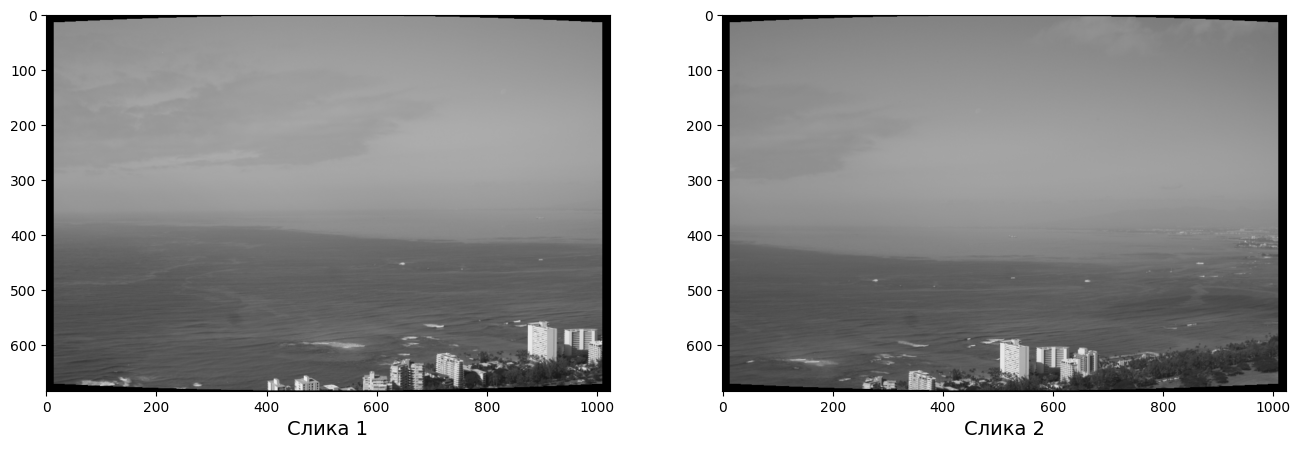

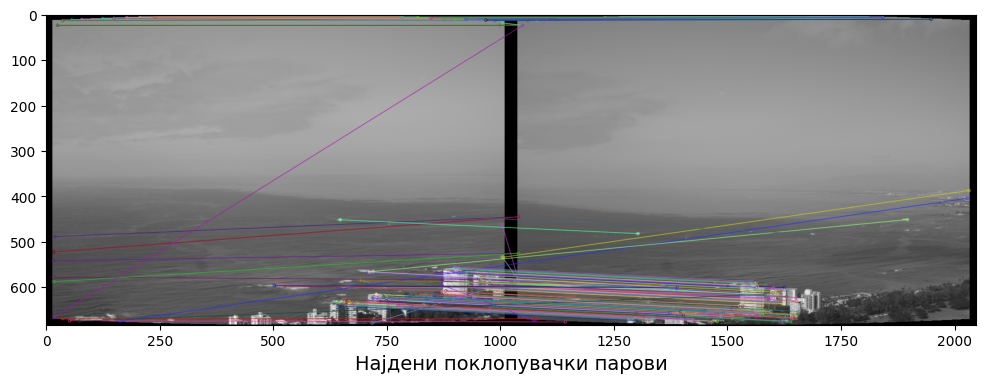

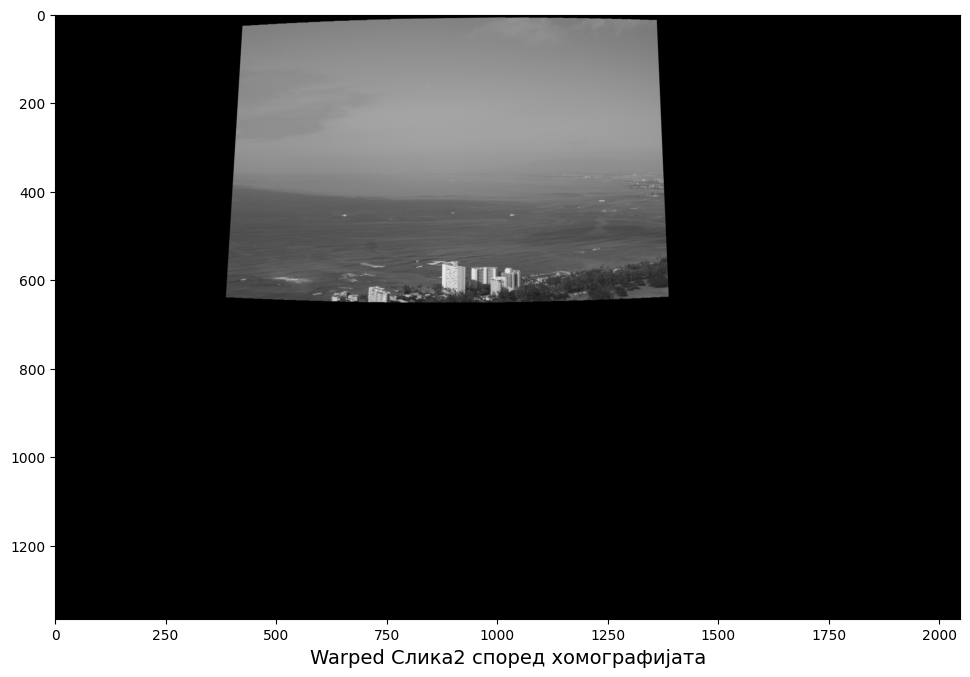

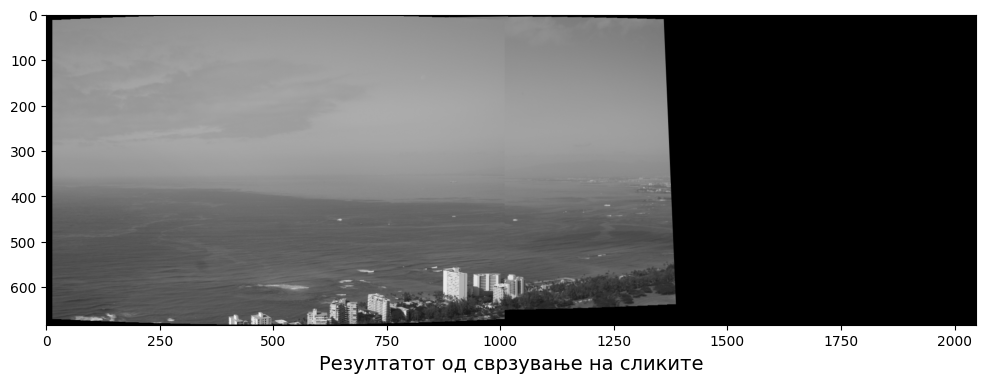

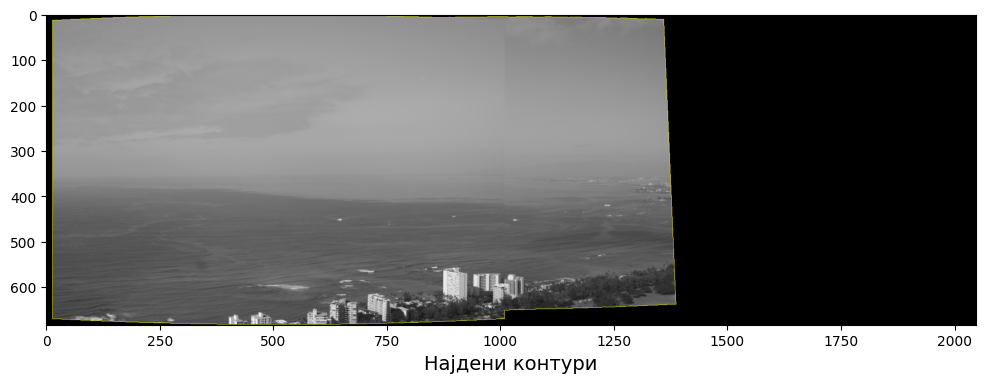

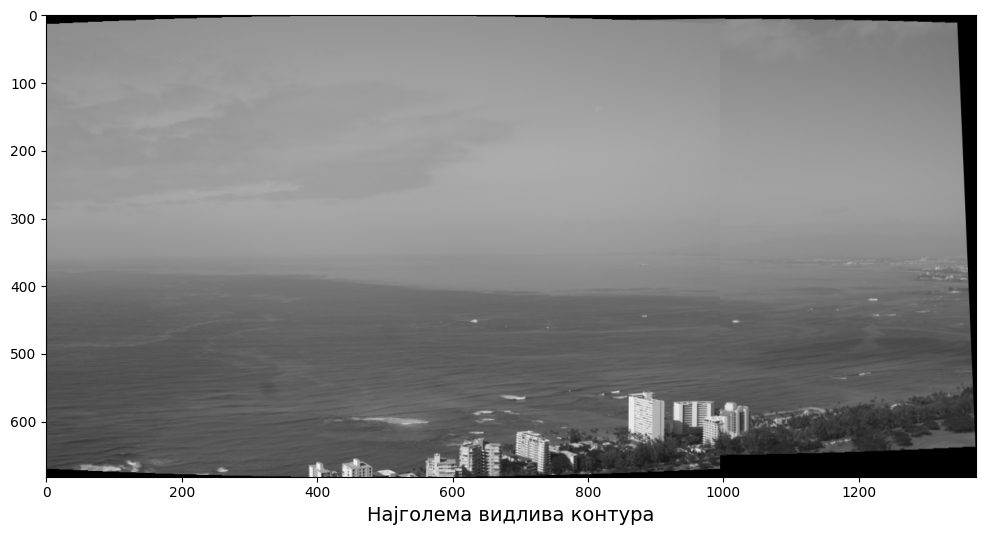

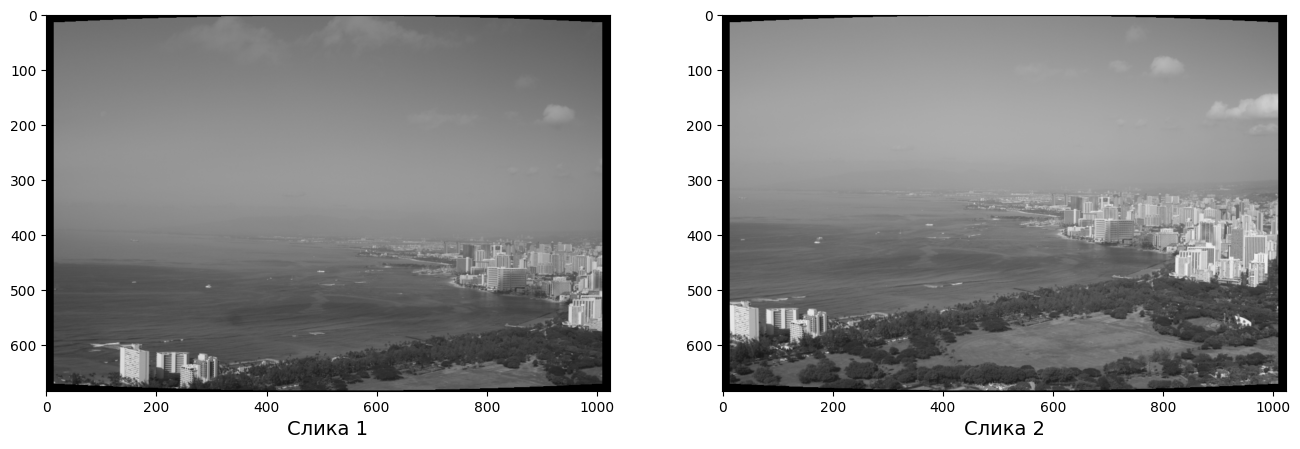

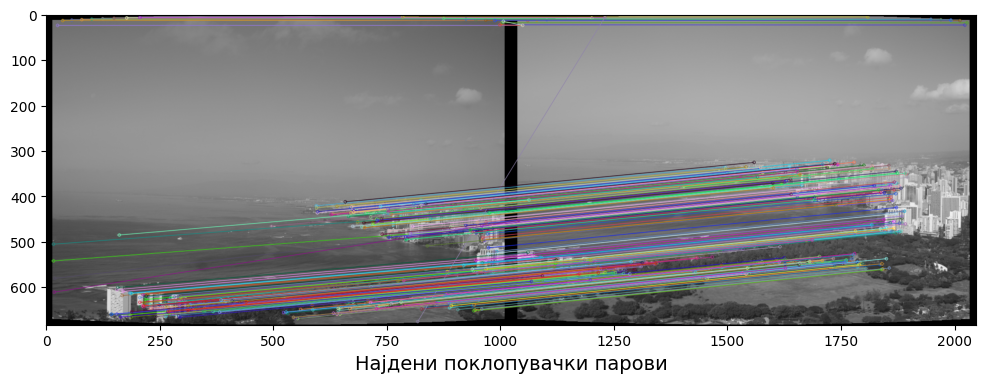

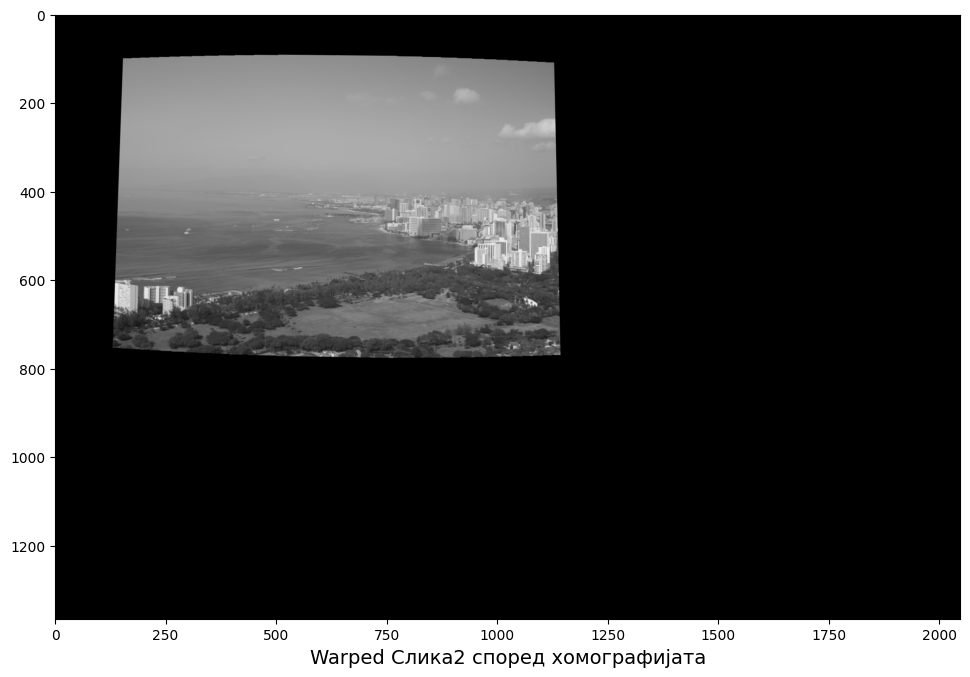

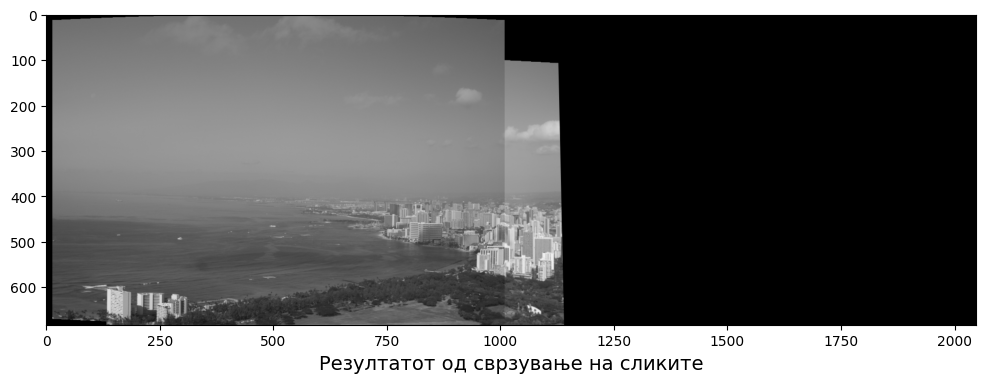

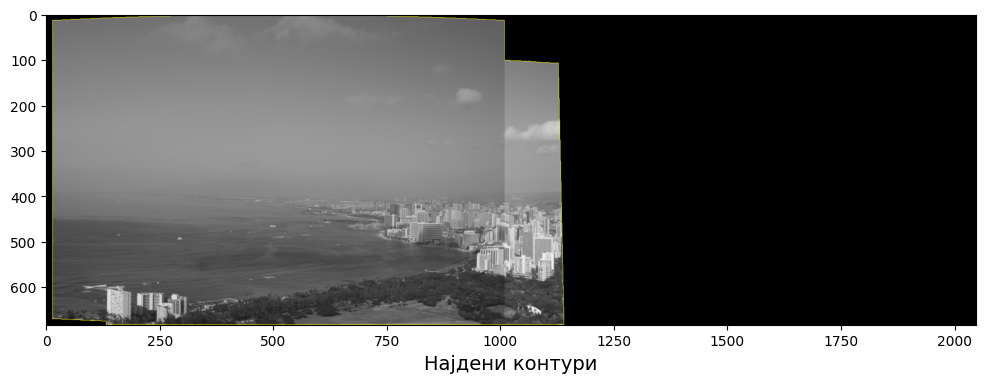

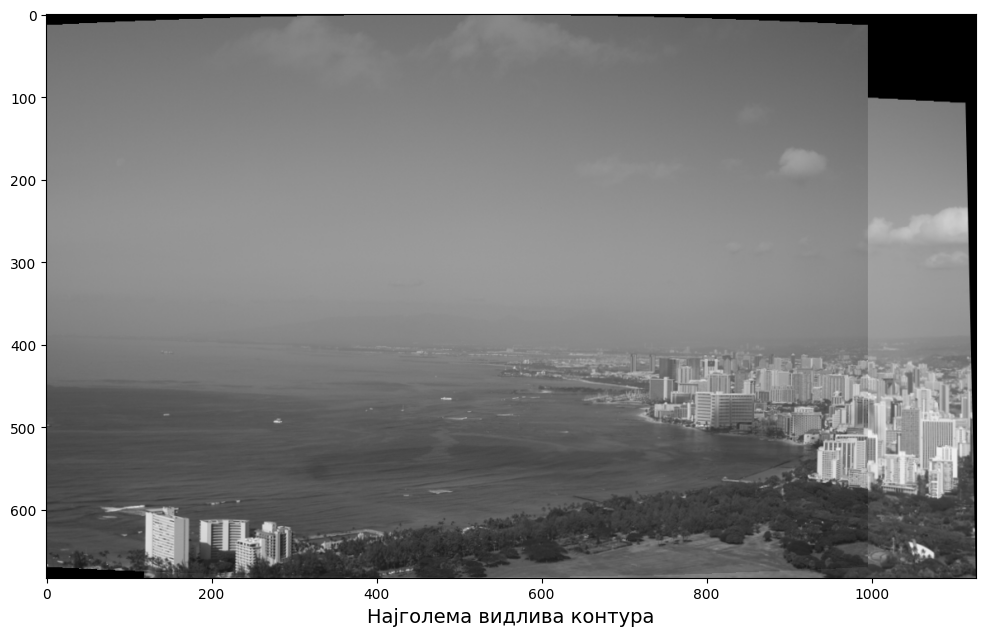

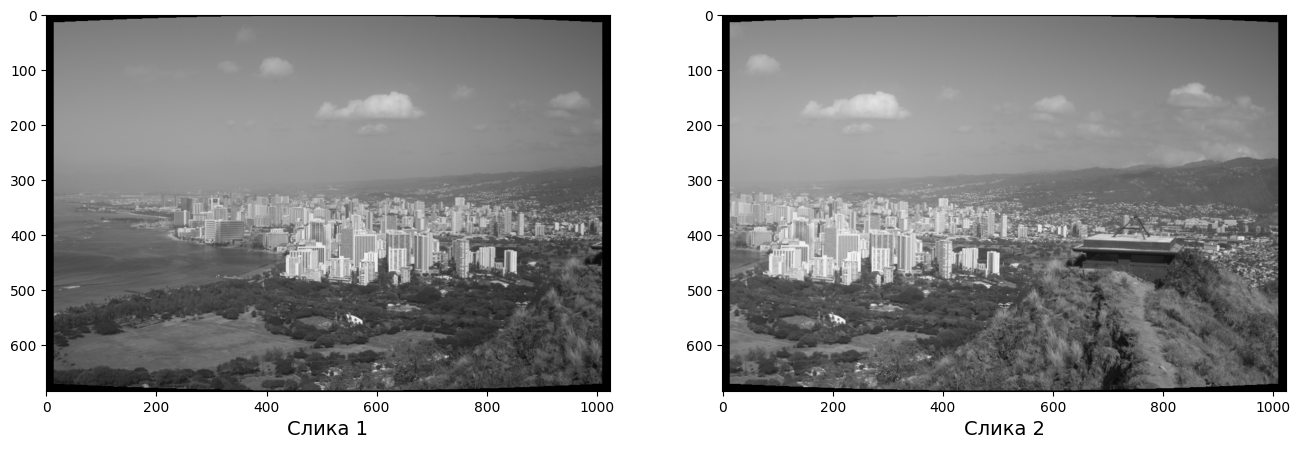

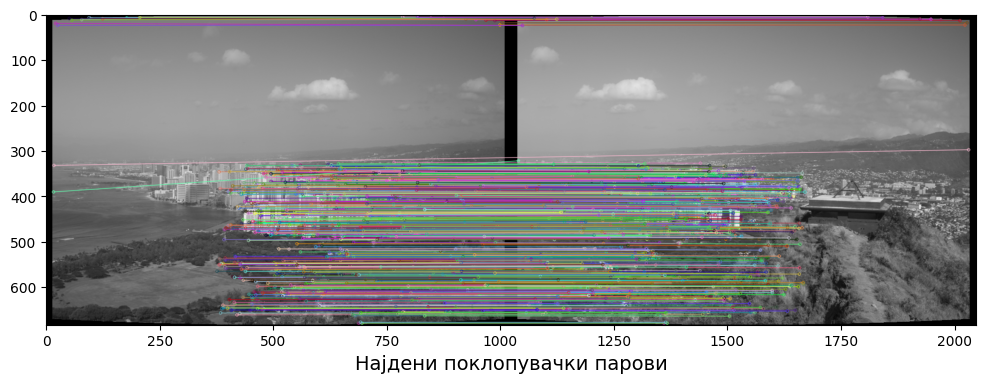

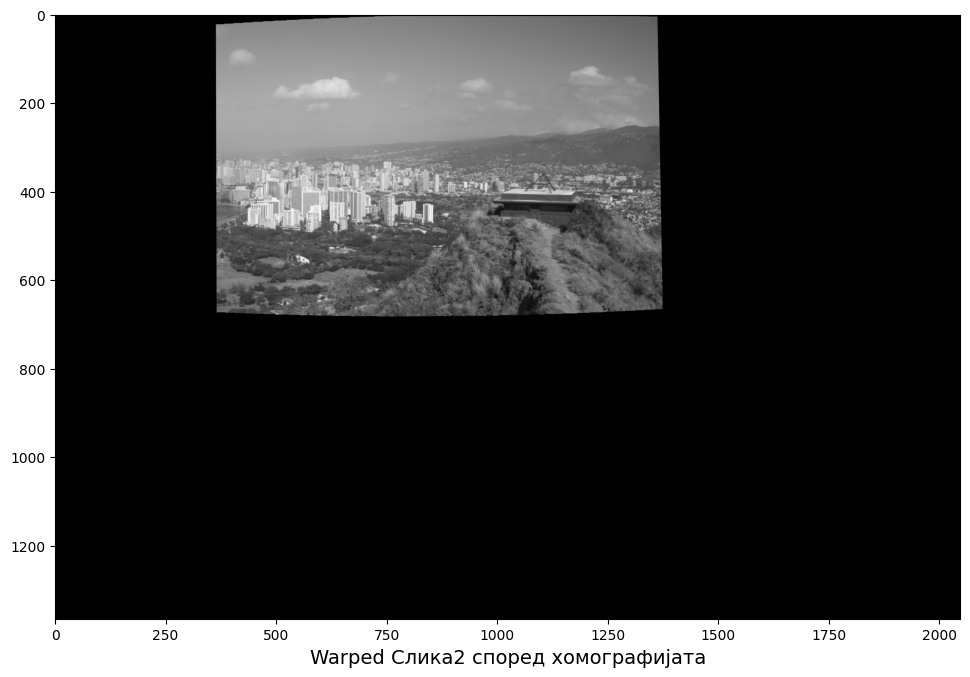

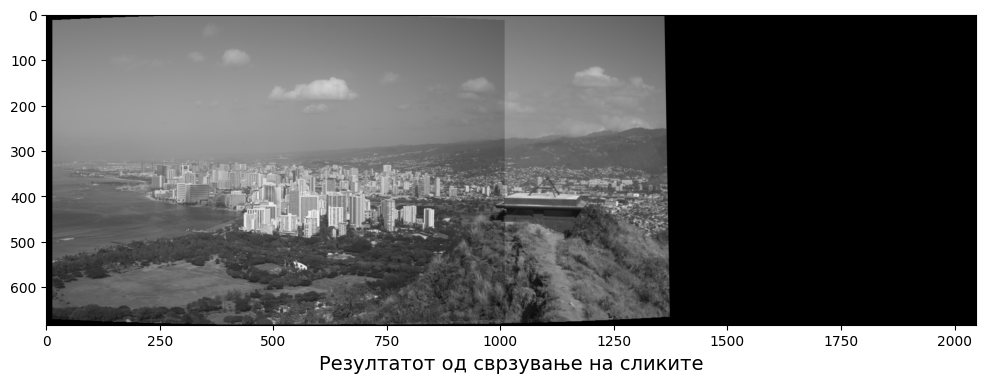

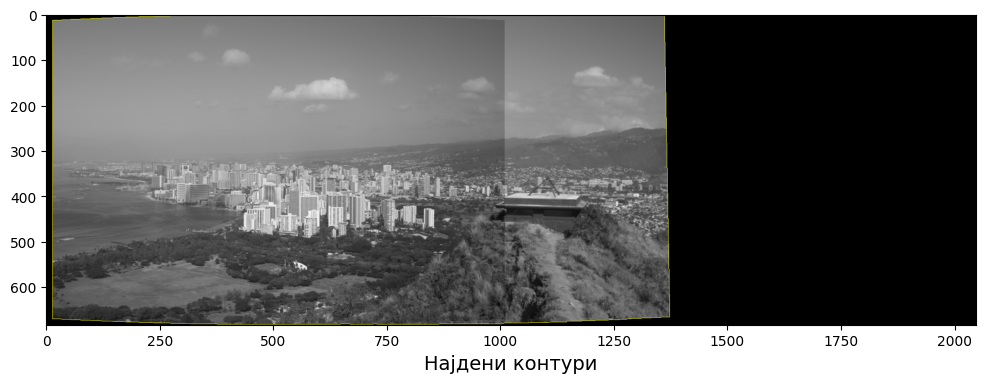

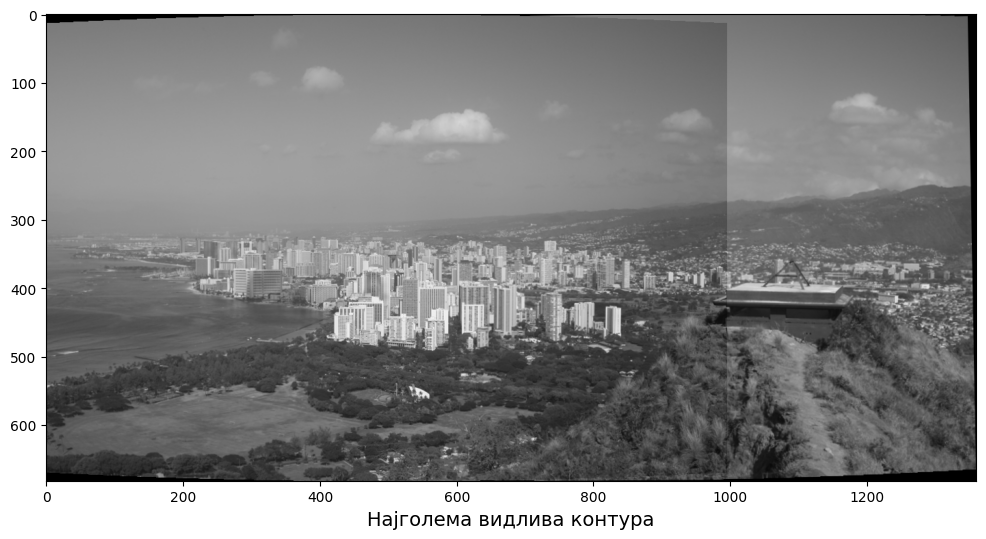

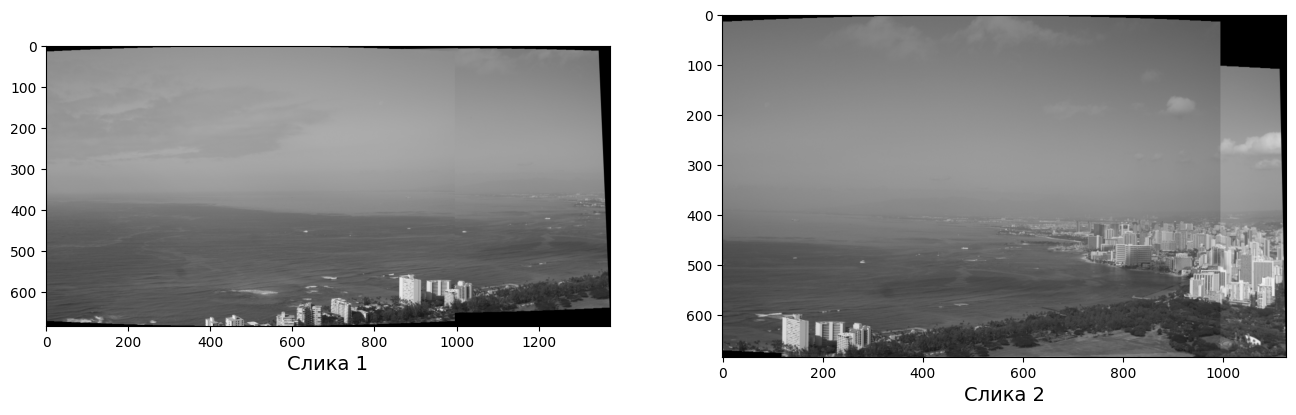

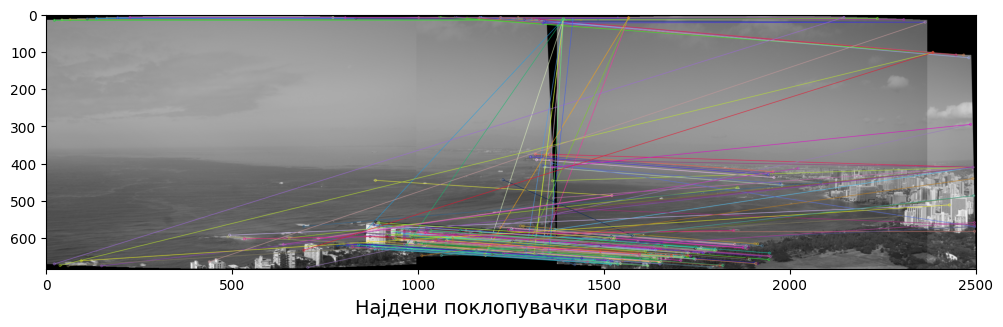

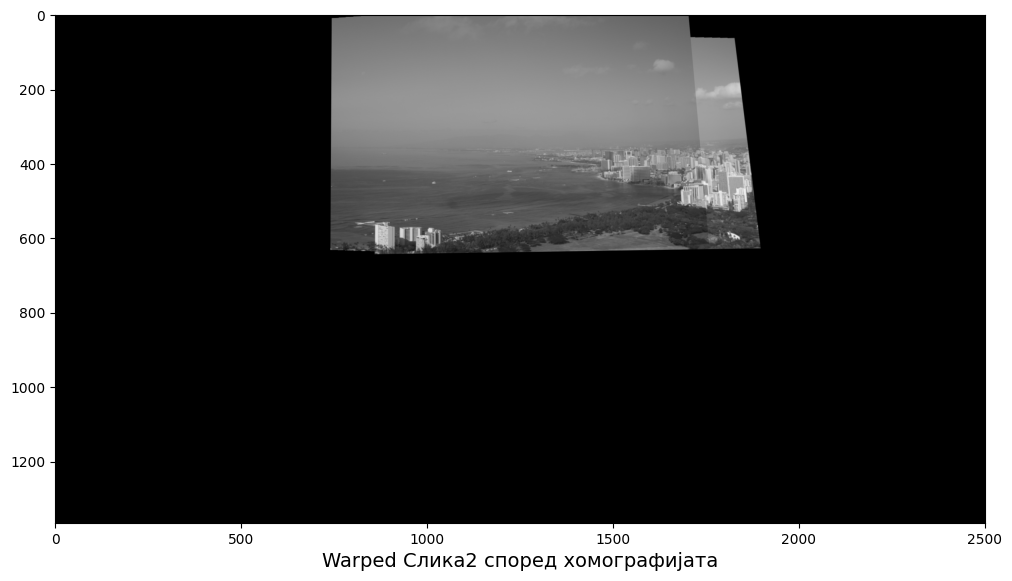

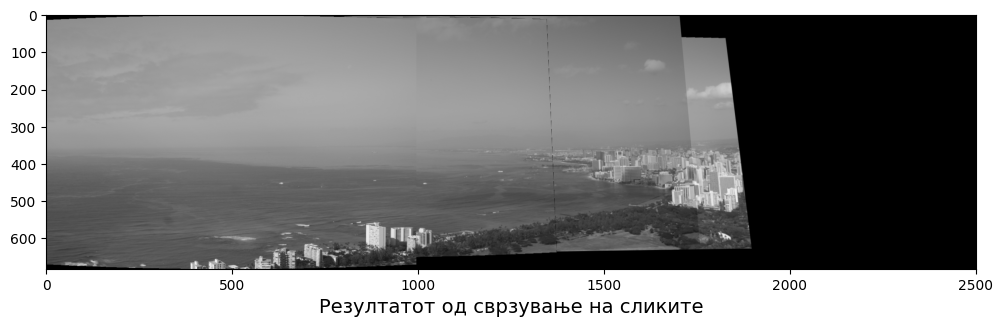

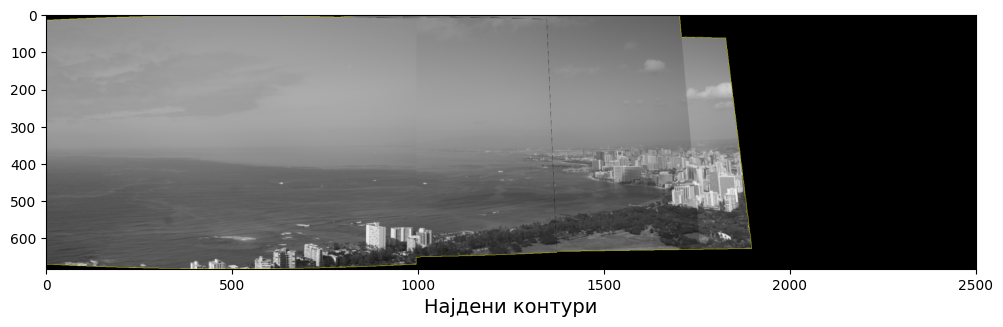

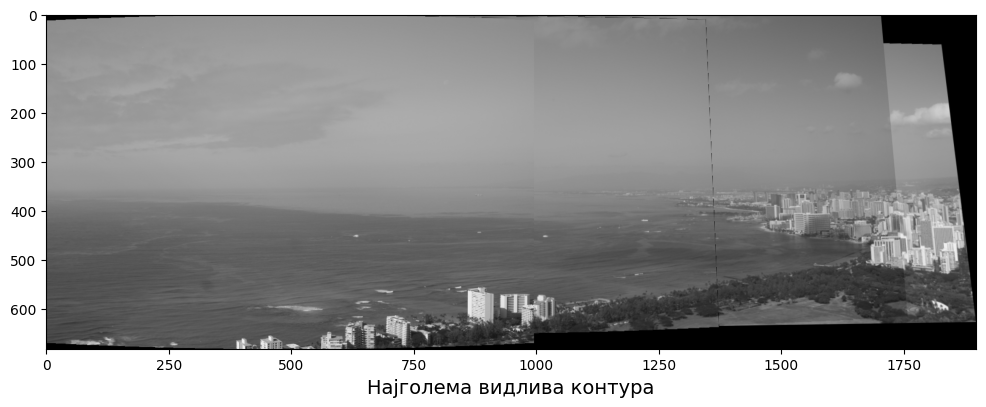

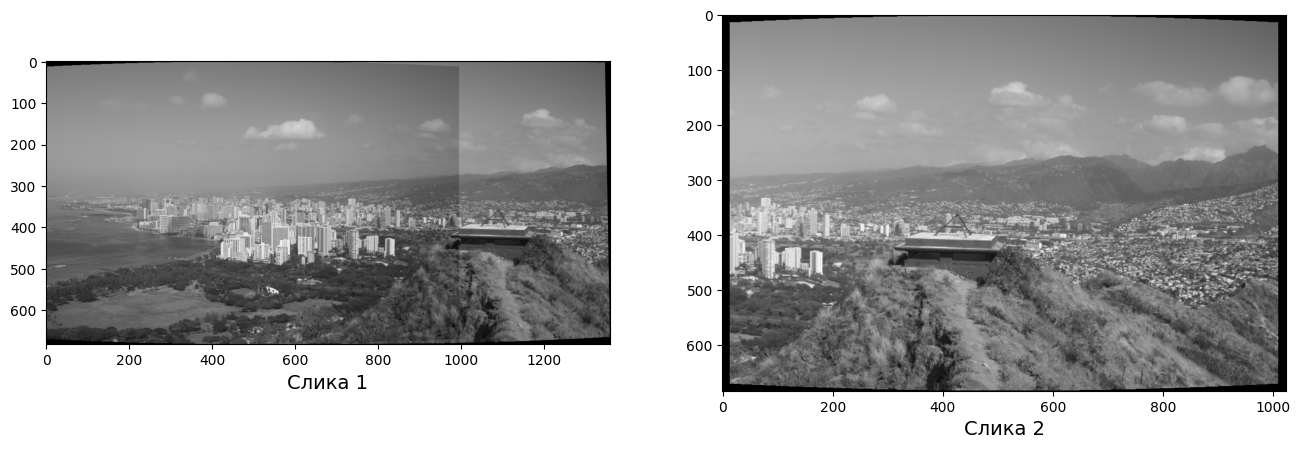

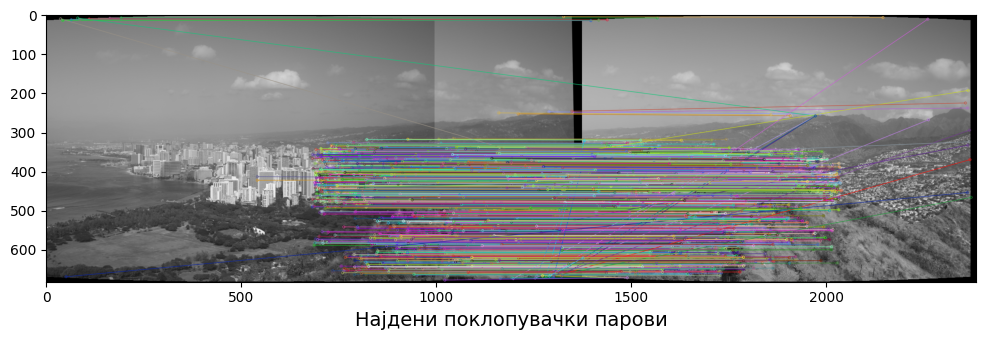

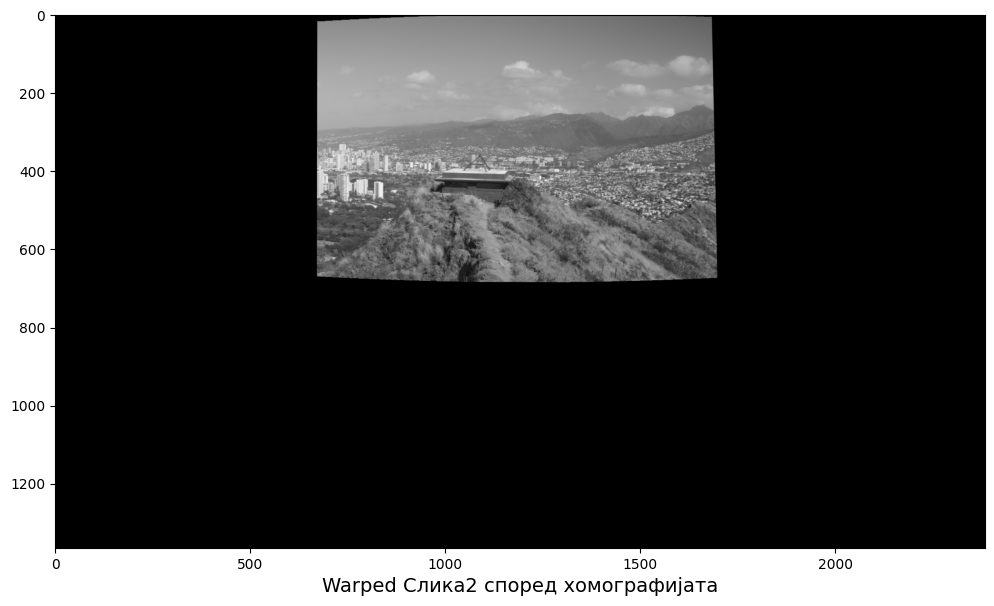

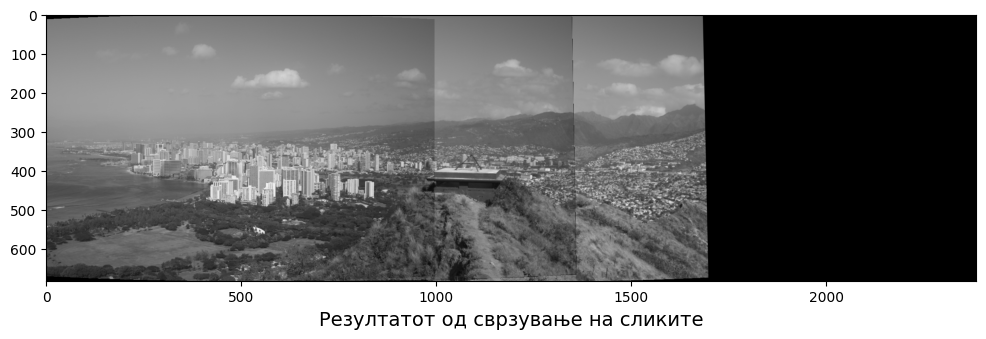

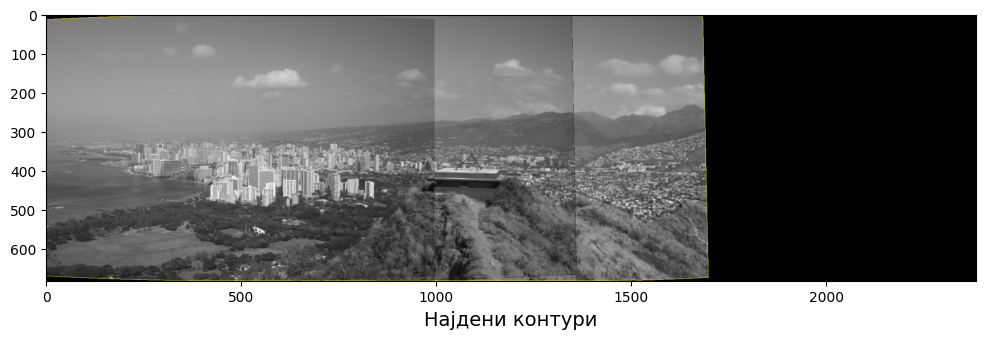

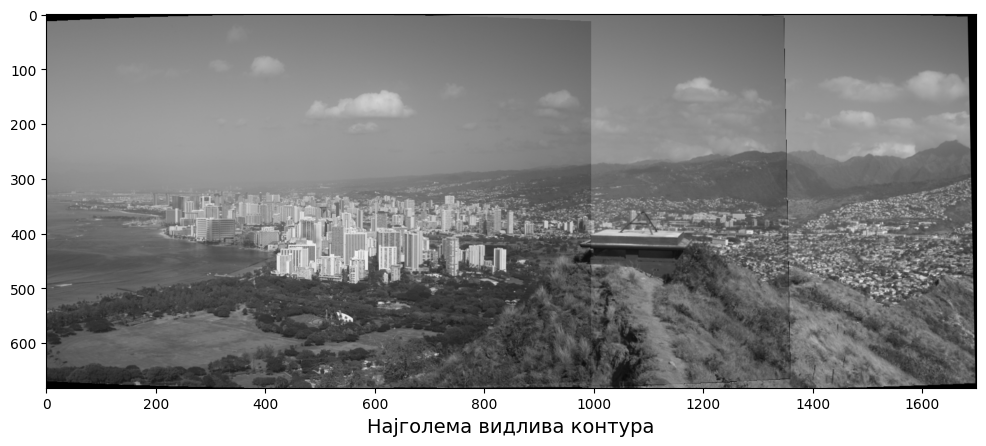

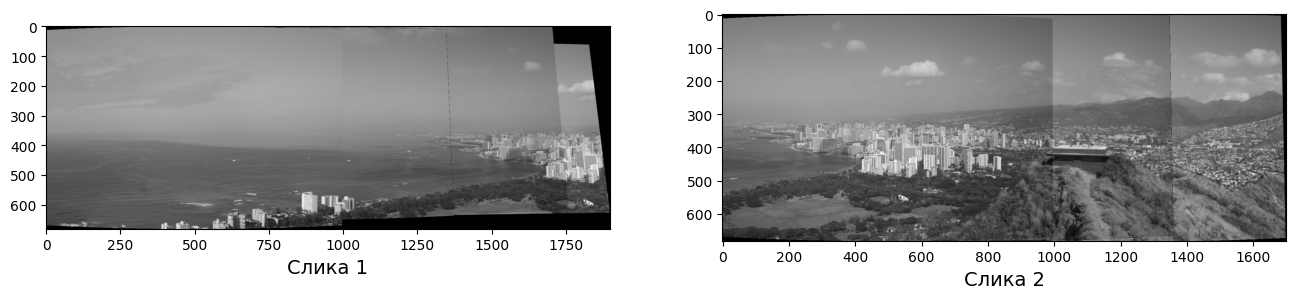

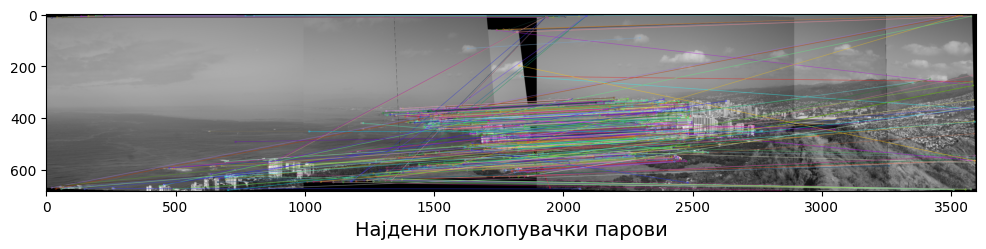

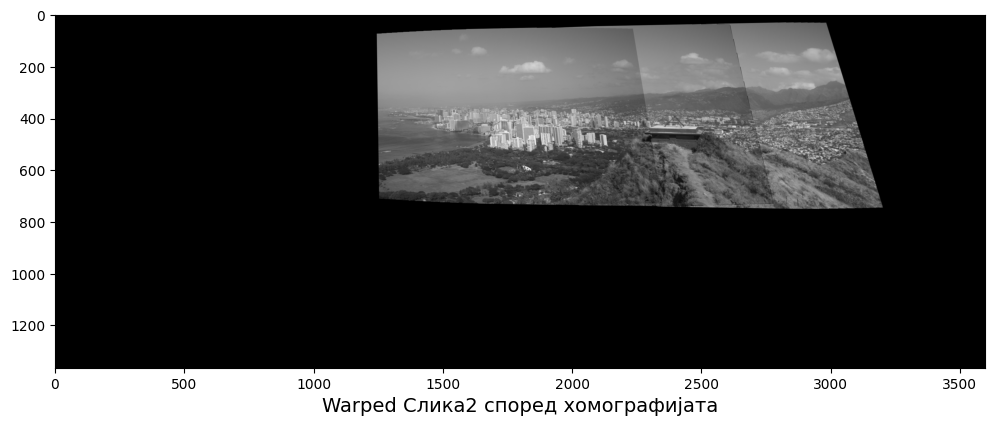

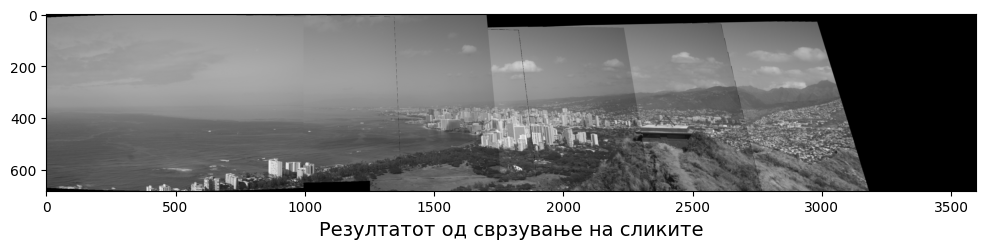

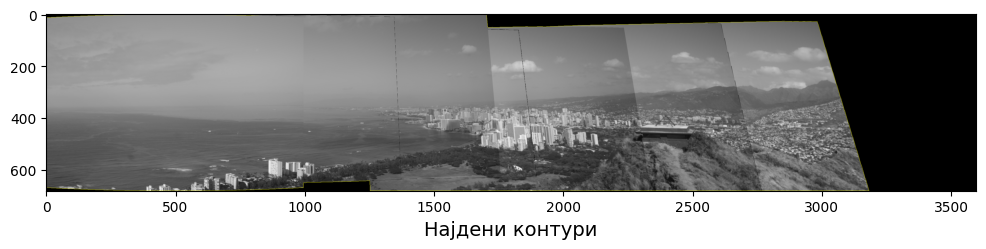

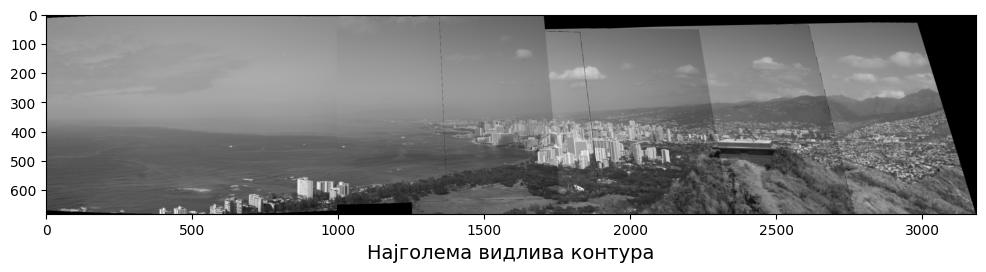

In [130]:
# Ќе се процесираат сликите 2 по 2, прво сите можни парови непроцесирани слики
# па потоа резултатите од тие процесирања, се додека немаме единствена слика во листата
pairwise_stitches = []
while(len(cylinder_images) > 1):
    while(len(cylinder_images) >= 2):
        img1 = cylinder_images[0]
        img2 = cylinder_images[1]
        
        stitched = stitch(img1, img2, descriptorDetector, matcherType, percentageMatches)        
        pairwise_stitches.append(stitched)

        cylinder_images.remove(img1)
        cylinder_images.remove(img2)

    if(len(cylinder_images) == 1):
        pairwise_stitches.append(cylinder_images.pop())

    cylinder_images.clear()
    cylinder_images.extend(pairwise_stitches)
    pairwise_stitches.clear()

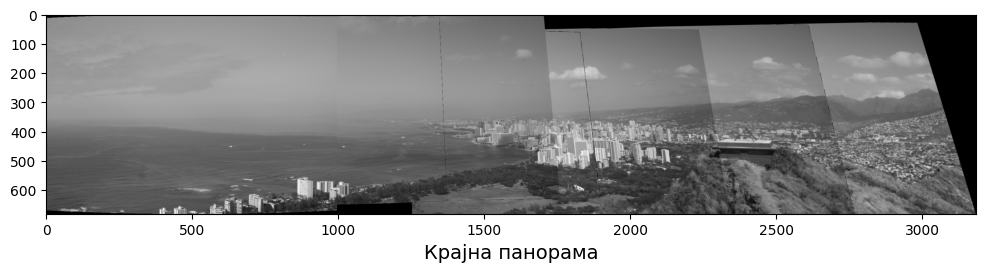

In [131]:
# Приказ на сите слики поврзани во една панорама
result = cylinder_images[0]
plt.xlabel("Крајна панорама", fontsize=14)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGRA2RGB))
plt.show()

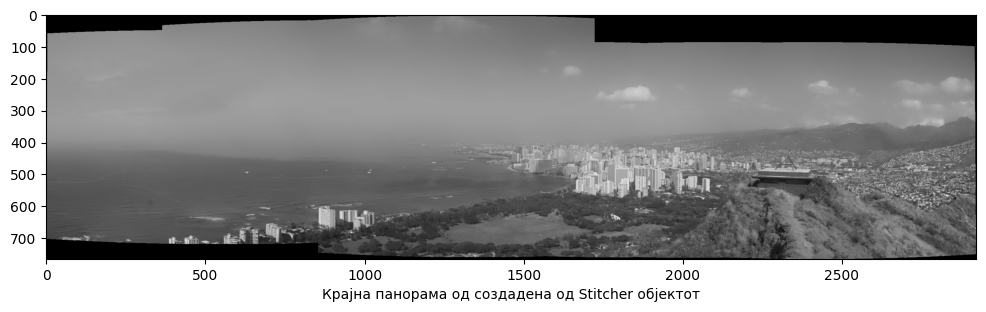

In [132]:
# Приказ на панорамата пресметана од Stitcher објектот на OpenCV
stitcher = cv2.Stitcher_create()
status, stitched = stitcher.stitch(images_copy_for_stitcher)
if status == 0:
    plt.xlabel("Крајна панорама од создадена од Stitcher објектот")
    plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
    plt.show()

In [133]:
# Излез на сликите
cv2.imwrite("output.png", result)
cv2.imwrite("output_Stitcher.png", stitched)

True